# MACE experiment notebook 

This experiment notebook tries to understand how to speed up varius part of [MACE](../Notes/General%20Concepts/MACE.md).

It relies on the different tutorial notebooks proposed by the [MACE repositery](https://github.com/ACEsuit/mace).

## Install dependencies

In [1]:
from mace import data, modules, tools
import numpy as np
import torch
import torch.nn.functional
from e3nn import o3
from matplotlib import pyplot as plt
import ase.io
%matplotlib inline
from ase.visualize import view
from scipy.spatial.transform import Rotation

from mace.tools import torch_geometric
# torch.set_default_dtype(torch.float64)
import warnings
warnings.filterwarnings("ignore")

from torch.profiler import profile, record_function, ProfilerActivity
import seaborn as sns
from typing import List, Tuple, Dict
import psutil
import os
from tqdm import tqdm
import time
from scipy.stats import wasserstein_distance



/Users/vinben007/Documents/University of Cambridge/MLMI-MPhil-Thesis-MACE/.venv/lib/python3.9/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


## Default model configuration

In [16]:
# setup some default prameters
z_table = tools.AtomicNumberTable([1, 6, 8])
atomic_energies = np.array([-1.0, -3.0, -5.0], dtype=float)
cutoff = 3

default_model_config = dict(
        num_elements=3,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("8x0e + 8x1o"),  # 8: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("16x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
    )
default_model = modules.MACE(**default_model_config)

## Precision Theory

✅ Summary: FP32 vs FP16

| Property          | FP32 (float32)       | FP16 (float16)                                          |
| ----------------- | -------------------- | ------------------------------------------------------- |
| Total bits        | 32                   | 16                                                      |
| Mantissa bits     | 23                   | 10                                                      |
| Decimal precision | \~7 digits           | \~3 digits                                              |
| Value range       | \~±$10^{38}$         | \~±$10^5$                                               |
| Memory usage      | 4 bytes / value      | 2 bytes / value                                         |
| Performance       | Slower, more precise | Faster, less precise                                    |
| Typical use       | Default for training | Efficient inference / low-precision training (with AMP) |


In [2]:
# Define a float32 tensor with high-precision value
vector_fp32 = torch.tensor([1.2345678], dtype=torch.float32)

# Convert to float16 (half precision)
vector_fp16 = vector_fp32.half()

# Print both values with full decimal precision
print(f"FP32 value  : {vector_fp32.item():.10f}")
print(f"FP16 value  : {vector_fp16.item():.10f}")

# Absolute error
error = torch.abs(vector_fp16.float() - vector_fp32)
print(f"Absolute error: {error.item():.10f}")

FP32 value  : 1.2345677614
FP16 value  : 1.2343750000
Absolute error: 0.0001927614


## T03-MACE-Theory.ipynb

### Speeding up Rotational Embedding

Speeding up the computation of spherical harmonics $Y_l^m(\hat{\mathbf{r}})$, and how do I verify whether lowering its precision has any significant impact?

We are going to make a benchmark for different dtype tensor calculation.

### Get the memory usage of each run

Gets the memory usage in megabytes

In [3]:
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

### Benchmark for spherical tensor calculations

- This function take an input vector which is torch.Tensor vector of default float32 type.
- Test different precision formats (fp32, fp16 and bf16)
- Returns different performance metrics such as:
    - Computation time
    - Memory usage
    - Output being the spherical harmonics (sh)

It creates spherical harmonics with l=2 and generates 360 rotated versinos of the input vector. It rotates it around the axis [0, 0.7071, 0.7071] which is $1/\sqrt(2)$

There is a warming loop to ensure accurate timing and it loops for x amount of runs


In [4]:
def benchmark_spherical_harmonics(vector: torch.Tensor, dtypes: Dict, l_max: int = 2, num_rotations: int = 360, 
                                  num_runs: int = 1000) -> Dict:
    results = {}
    
    # init spherical harmonics
    sh = o3.SphericalHarmonics([l for l in range(l_max + 1)], True)
    
    # gen rotated vectors
    vector_np = vector.numpy()
    rotated_vectors = []
    for i in range(num_rotations):
        rotation_matrix = Rotation.from_rotvec(
            i * 2*np.pi * np.array([0, 0.7071, 0.7071])/num_rotations
        ).as_matrix()
        rotated_vectors.append(rotation_matrix @ vector_np)
    rotated_vectors = torch.tensor(rotated_vectors, dtype=torch.float32)
    
    for dtype_name, dtype in dtypes.items():
        # convert the vector to specified dtype
        vecs = rotated_vectors.to(dtype)
        
        # Warmup
        for _ in range(10):
            _ = sh(vecs)
        
        # computation time
        start_time = time.time()
        for _ in tqdm(range(num_runs)):
            _ = sh(vecs)
        end_time = time.time()
        
        results[dtype_name] = {
            'computation_time': (end_time - start_time) / num_runs,
            'memory_usage': get_memory_usage(),
            'output': sh(vecs)
        }
    
    return results

### Calculate errors

Calculate different kind of errors between the different computation with for reference fp32 (can obviously be changed if we need to compare something else)

In [5]:
def calculate_errors(reference: torch.Tensor, comparison: torch.Tensor) -> Dict:
    reference_f32 = reference.to(torch.float32)
    comparison_f32 = comparison.to(torch.float32)
    
    return {
        'mean_absolute_error': torch.mean(torch.abs(reference_f32 - comparison_f32)).item(),
        'max_absolute_error': torch.max(torch.abs(reference_f32 - comparison_f32)).item(),
        'wasserstein_distance': wasserstein_distance(
            reference_f32.flatten().cpu().numpy(),
            comparison_f32.flatten().cpu().numpy()
        )
    }

### Plot the results

It shows how spherical harmonics values change with rotation and compares performance across different precision formats

- Speed comparison (computation time)
- Memeory usage (megabytes)
- Error rate (uses calculate_errors function)
- Plot the angular variation for each dtype

In [14]:
def plot_results(results: Dict):
    # Speed comparison
    plt.figure(figsize=(10, 6))
    speeds = [results[dtype]['computation_time'] for dtype in results.keys()]
    plt.bar(results.keys(), speeds)
    plt.title('Computation Speed Comparison')
    plt.ylabel('Time (s)')
    plt.savefig('images/speed_comparison.png')
    
    # Memory usage
    plt.figure(figsize=(10, 6))
    memory = [results[dtype]['memory_usage'] for dtype in results.keys()]
    plt.bar(results.keys(), memory)
    plt.title('Memory Usage Comparison')
    plt.ylabel('Memory (MB)')
    plt.savefig('images/memory_usage.png')
    
    # Error analysis
    reference = results['fp32']['output']
    errors = {}
    for dtype in ['fp16', 'fp64']:
        errors[dtype] = calculate_errors(reference, results[dtype]['output'])
    
    plt.figure(figsize=(12, 6))
    for dtype, error in errors.items():
        plt.hist(
            (results[dtype]['output'] - reference).flatten().cpu().numpy(),
            bins=50,
            alpha=0.5,
            label=dtype
        )
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('images/error_histogram.png')
    
    # Angular variation from og code
    plt.figure(figsize=(12, 6))
    labels = [[f'l={l}, m={m}' for m in range(-l,l+1)] for l in range(3)]
    labels = [x for xs in labels for x in xs]  # flatten
    
    for dtype in results.keys():
        plt.plot(
            results[dtype]['output'].cpu().numpy(),
            label=f'{dtype}',
            alpha=0.7
        )
    plt.title('Angular Variation')
    plt.xlabel('Rotation angle')
    plt.ylabel('Spherical harmonic value')
    plt.legend(labels)
    plt.savefig('images/angular_variation.png')

### Runs the spherical harmonics study

Running spherical harmonics benchmarks...


100%|██████████| 1000/1000 [00:00<00:00, 16289.07it/s]


Benchmark Results:

fp64:
Computation time: 0.000058 seconds
Memory usage: 405.78 MB

fp32:
Computation time: 0.000043 seconds
Memory usage: 405.78 MB

fp16:
Computation time: 0.000062 seconds
Memory usage: 405.78 MB

Generating plots...


Plots saved as: speed_comparison.png, memory_usage.png, error_histogram.png, angular_variation.png


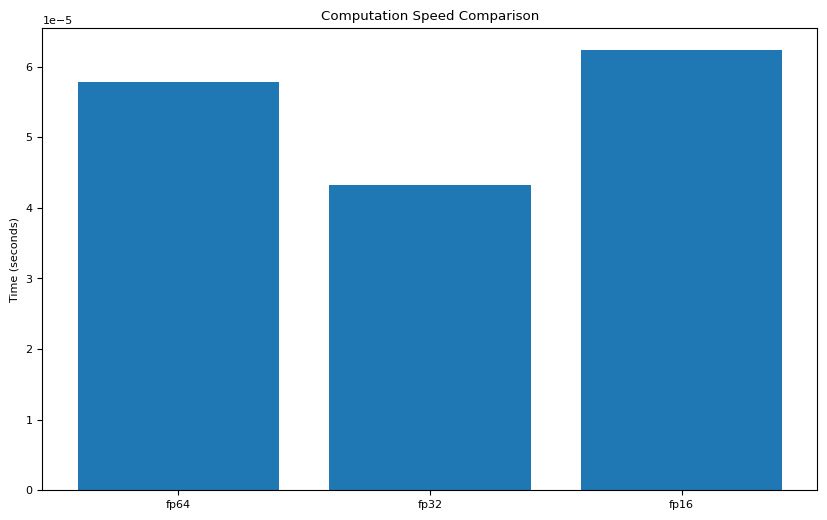

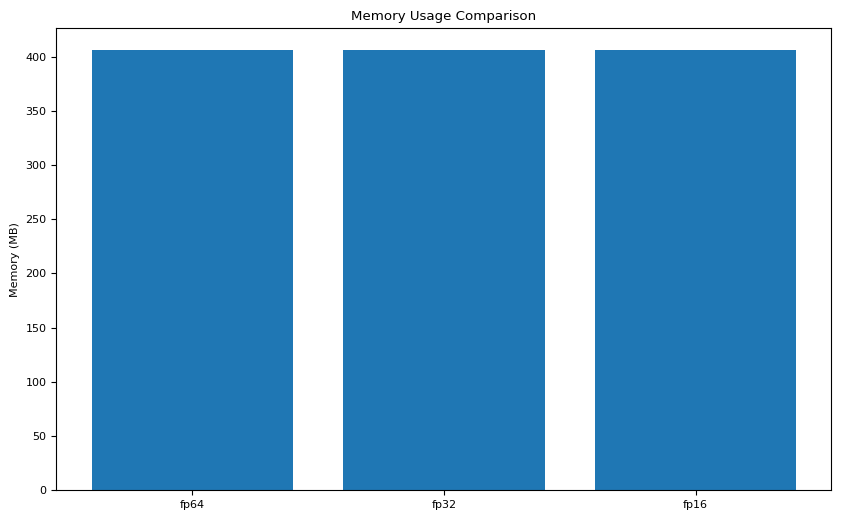

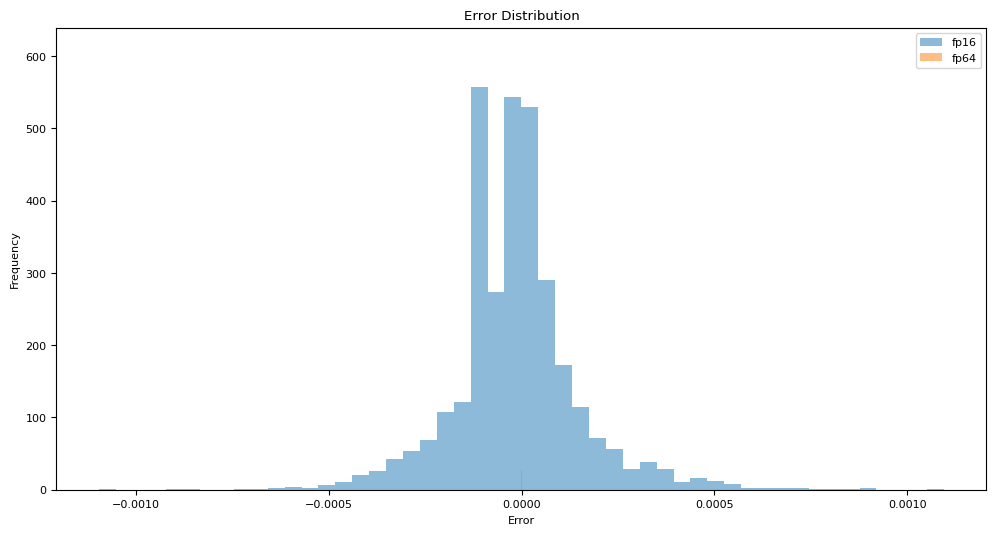

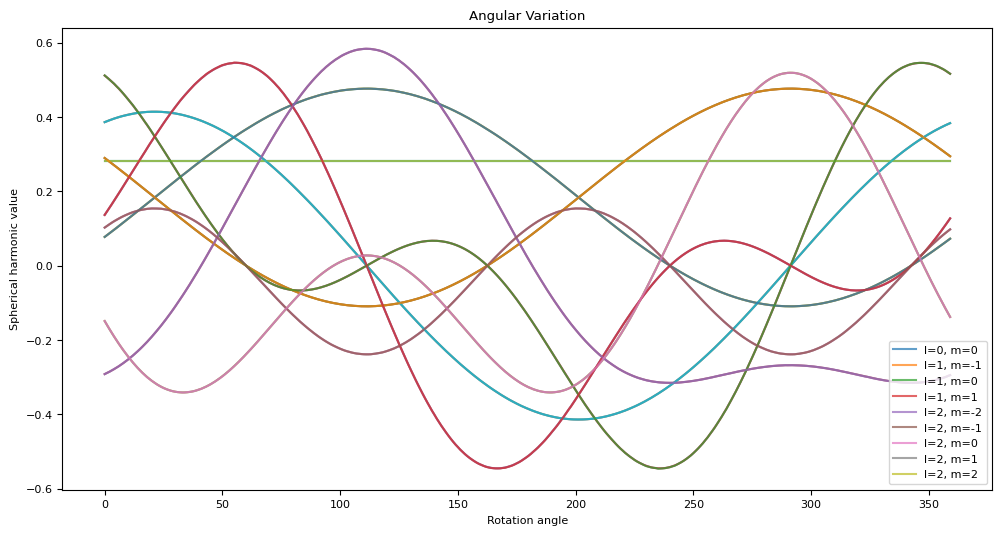

In [15]:
# Generate test vector (from og code)
vector = torch.tensor([1.0, 0.2, 0.75], dtype=torch.float32)

dtypes = {
    'fp64': torch.float64,
    'fp32': torch.float32,
    'fp16': torch.float16,
    # 'bf16': torch.bfloat16,
}

print("Running spherical harmonics benchmarks...") # debugging step
results = benchmark_spherical_harmonics(vector, dtypes)

print("\nBenchmark Results:") # debugging step
for dtype, metrics in results.items():
    print(f"\n{dtype}:")
    print(f"Computation time: {metrics['computation_time']:.6f} seconds")
    print(f"Memory usage: {metrics['memory_usage']:.2f} MB")

print("\nGenerating plots...") # debugging step
plot_results(results)
print("Plots saved as: speed_comparison.png, memory_usage.png, error_histogram.png, angular_variation.png")